# Step 3: Scientific Evaluation & Error Analysis

In this notebook, we load the trained **ResNet50** model (from Phase 2) and perform a comprehensive evaluation on the **Test Set**.

### Goals:
1. Calculate **Accuracy**, **Precision**, **Recall**, and **F1-Score**.
2. Visualize the **Confusion Matrix** to understand misclassifications.
3. Perform **Qualitative Error Analysis** by visualizing False Positives.

In [1]:
# --- Setup & Imports ---
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.notebook import tqdm

# Add 'src' to path (Go up one level from notebooks/)
sys.path.append(os.path.abspath('..'))

from src.preprocessing.dataset import create_dataloaders
from src.models.models import get_model
from src.utils.utils import set_seed

# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🚀 Using Device: {DEVICE}")

🚀 Using Device: cuda


### 1. Load Data & Model
We load the test split and the best weights saved during training.

In [2]:
# 1. Load Data
dataloaders, datasets = create_dataloaders(
    splits_dir='../data/processed/splits',
    root_dir='..',
    batch_size=32
)

# Load Class Mapping
mapping_path = '../data/processed/splits/class_mapping.json'
with open(mapping_path) as f:
    mapping = json.load(f)
    class_names = [mapping[str(i)] for i in range(len(mapping))]

num_classes = len(class_names)
print(f"Classes: {num_classes}")

# 2. Initialize Model
model = get_model('resnet50', num_classes=num_classes, device=DEVICE)

# 3. Load Weights
checkpoint_path = '../models/best_model_resnet50.pth'
if os.path.exists(checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path, map_location=DEVICE))
    print("✅ Weights loaded successfully.")
else:
    print("❌ Checkpoint not found! Make sure you ran training first.")

Classes: 27
✅ Weights loaded successfully.


### 2. Run Inference
We iterate over the test set to get predictions. We also store incorrect predictions for visualization.

In [3]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    error_samples = [] # (img_tensor, true_label, pred_label)

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Inference"):
            inputs = inputs.to(DEVICE)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Convert to numpy
            preds_np = preds.cpu().numpy()
            labels_np = labels.numpy()
            
            all_preds.extend(preds_np)
            all_labels.extend(labels_np)
            
            # Find errors
            incorrect_mask = preds_np != labels_np
            if incorrect_mask.any():
                for i in np.where(incorrect_mask)[0]:
                    if len(error_samples) < 16: # Keep top 16 errors
                        error_samples.append((inputs[i].cpu(), labels_np[i], preds_np[i]))
                        
    return np.array(all_labels), np.array(all_preds), error_samples

y_true, y_pred, errors = get_predictions(model, dataloaders['test'])

Inference:   0%|          | 0/107 [00:00<?, ?it/s]

### 3. Quantitative Analysis (Metrics)
Accuracy, Precision, Recall, and F1-Score.

In [4]:
acc = accuracy_score(y_true, y_pred)
print(f"🏆 Test Accuracy: {acc:.4f}")
print("-"*30)
print(classification_report(y_true, y_pred, target_names=class_names))

🏆 Test Accuracy: 0.5265
------------------------------
                            precision    recall  f1-score   support

    Abstract_Expressionism       0.41      0.61      0.49       150
           Action_painting       0.50      0.27      0.35        15
         Analytical_Cubism       1.00      0.71      0.83        17
        Art_Nouveau_Modern       0.53      0.37      0.43       150
                   Baroque       0.49      0.37      0.42       150
      Color_Field_Painting       0.75      0.59      0.66       150
      Contemporary_Realism       0.47      0.49      0.48        72
                    Cubism       0.53      0.62      0.57       150
         Early_Renaissance       0.72      0.77      0.74       150
             Expressionism       0.28      0.33      0.30       150
                   Fauvism       0.65      0.44      0.53       140
          High_Renaissance       0.51      0.49      0.50       150
             Impressionism       0.35      0.63      0.45   

### 4. Confusion Matrix
This heatmap shows which styles are confused with each other.

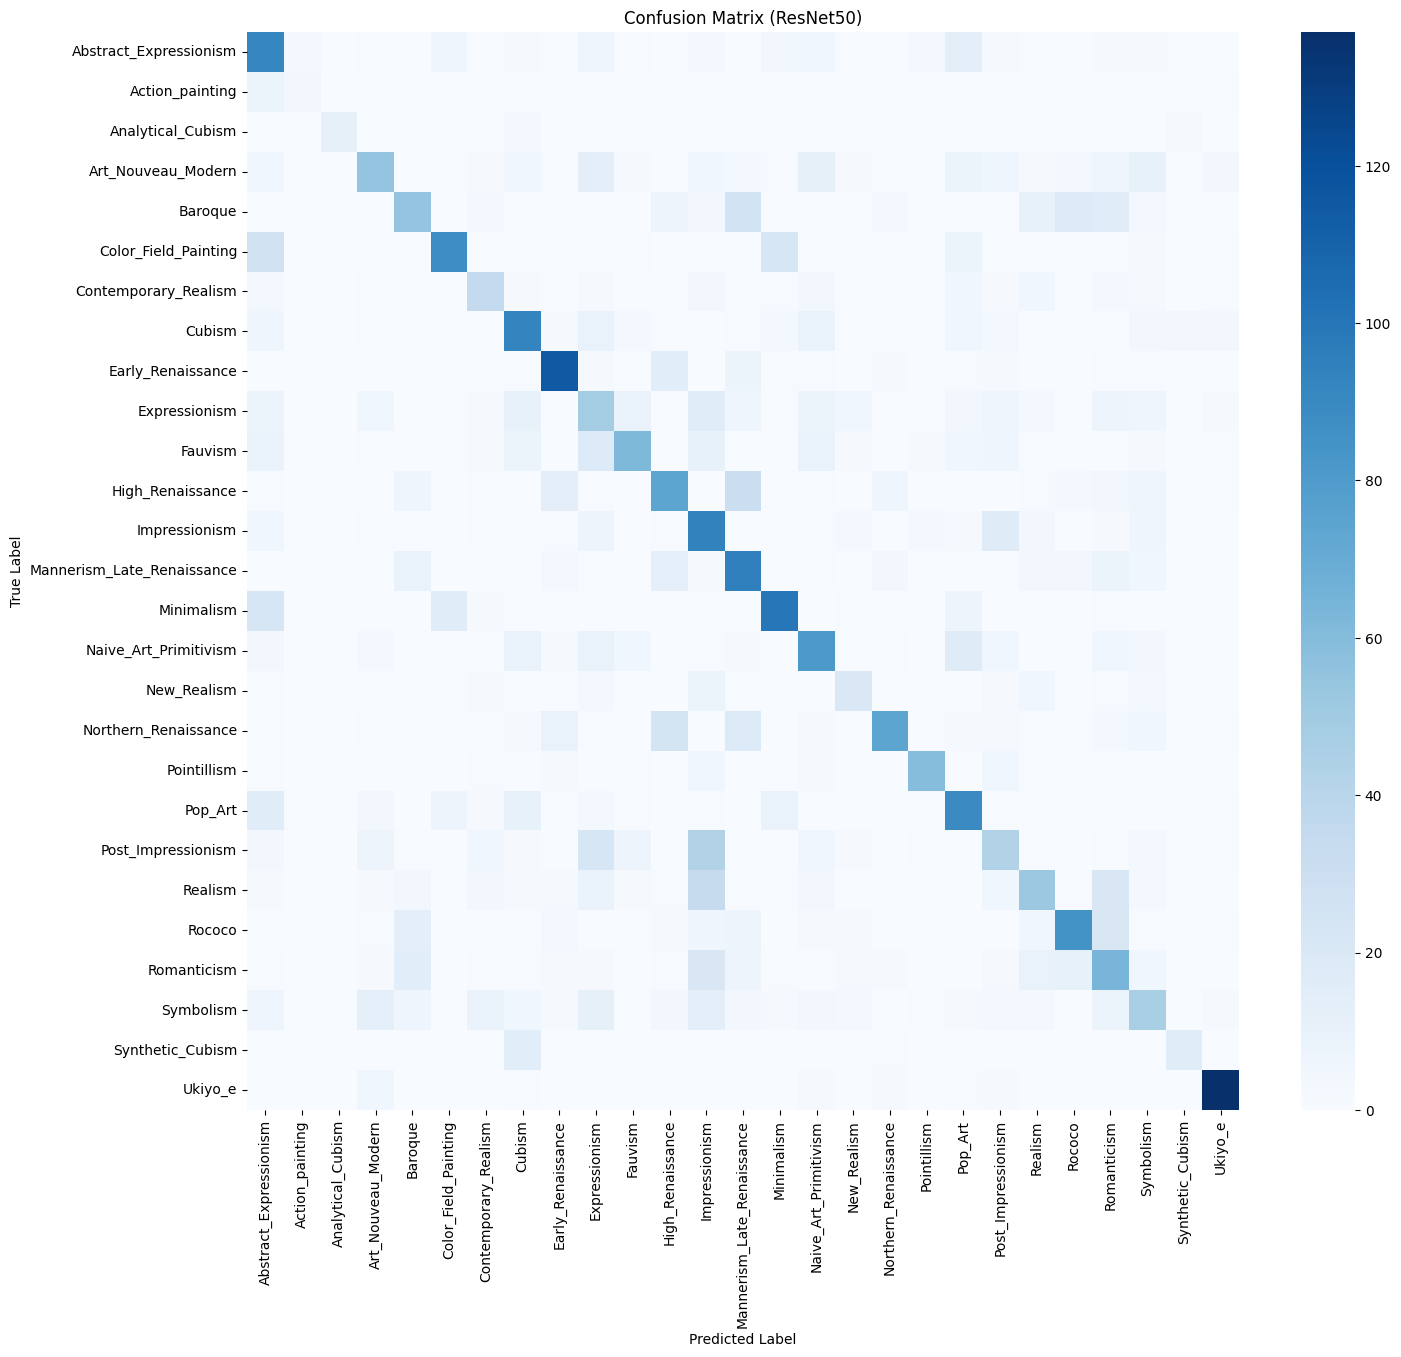

In [5]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (ResNet50)')
plt.xticks(rotation=90)
plt.show()

### 5. Qualitative Error Analysis
Visualizing images where the model made a mistake. This is crucial for understanding the model's weaknesses (e.g., confusing Impressionism with Post-Impressionism).

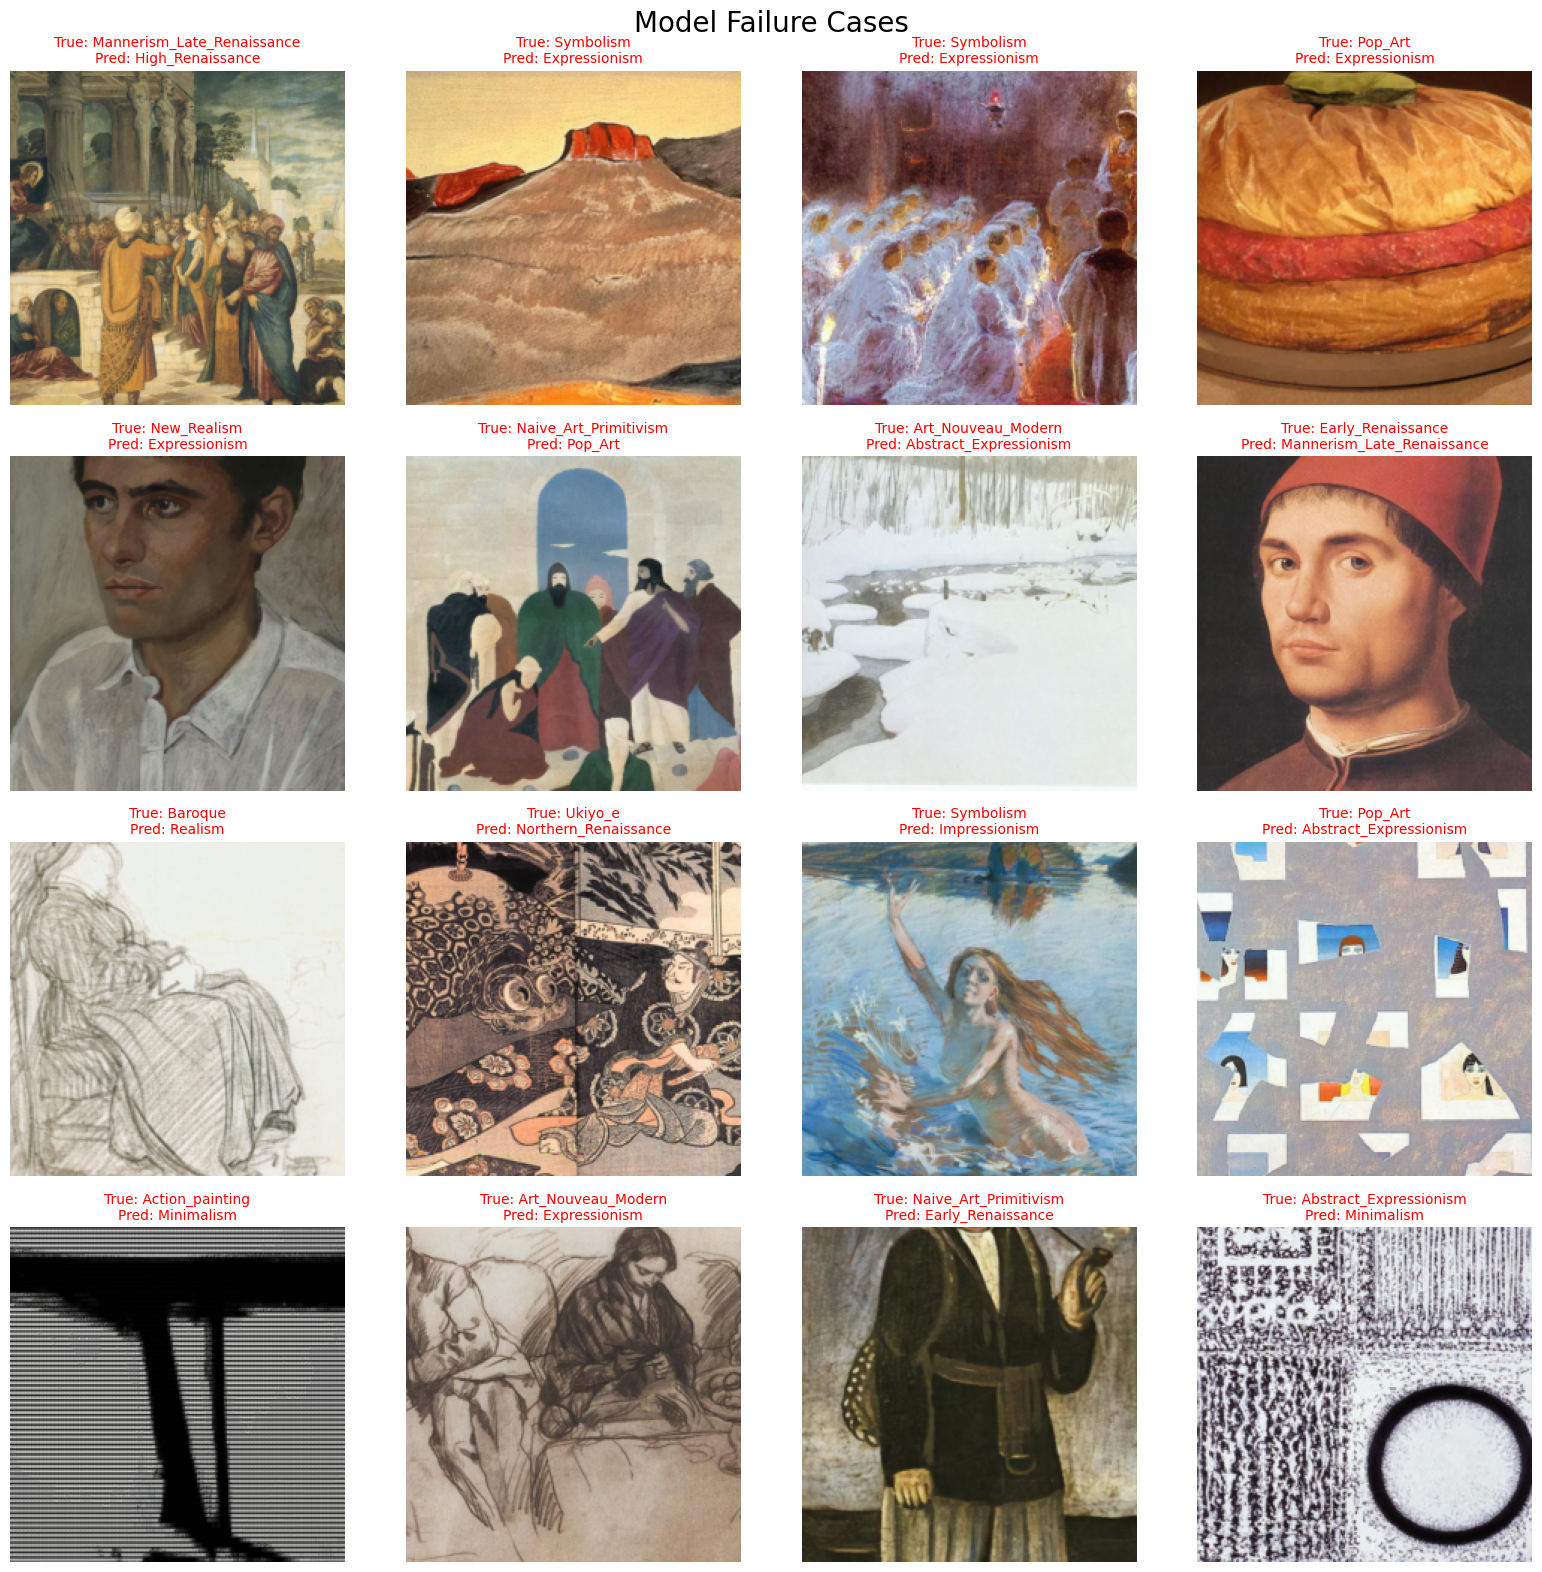

In [6]:
# Helper to un-normalize image for display
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])

def show_errors(errors, class_names):
    plt.figure(figsize=(16, 16))
    rows = int(np.ceil(np.sqrt(len(errors))))
    cols = int(np.ceil(len(errors) / rows))
    
    for i, (img_tensor, true_idx, pred_idx) in enumerate(errors):
        img = img_tensor.numpy().transpose((1, 2, 0))
        img = img * STD + MEAN
        img = np.clip(img, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[true_idx]}\nPred: {class_names[pred_idx]}", color='red', fontsize=10)
        plt.axis('off')
    
    plt.suptitle("Model Failure Cases", fontsize=20)
    plt.tight_layout()
    plt.show()

show_errors(errors, class_names)